# Introduction
In this project, we are asked to analyze a dataset and answer some questions from the dataset. I'll choose the Titanic dataset to discover if survival rate differs in gender, class and age. 
Questions need to solve:
   1. If survival rate is different within class.
   2. If survival rate is different within gender.
   3. If survival rate is different within different age groups.

# Starting the analysis

### 1. Data wrangling

In [1]:
#import packages needed
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
#import dataset
dt = pd.read_csv('train.csv')

In [3]:
#show the data
dt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Leave only relevant features in the dataset 
dt = dt[['Survived','Pclass','Sex','Age']]

Because i only want to analyze of Pclass, Sex and Age would influence the survival rate, i'll only leave the above 4 columns

In [5]:
#check dimension of data
dt.shape

(891, 4)

In [6]:
#check if there're missing values
dt.isnull().sum(0)

Survived      0
Pclass        0
Sex           0
Age         177
dtype: int64

In [7]:
#convert age into bucket and fill NA with 'unknown'

#find the max age in order to bucket the age
max(dt['Age'])

80.0

In [8]:
#function of bucket age
def age_bucket(x):
    if x <= 10:
        return '0-10'
    elif x <= 20:
        return '11-20'
    elif x <= 30:
        return '21-30'
    elif x <= 40:
        return '31-40'
    elif x <= 50:
        return '41-50'
    elif x <= 60:
        return '51-60'
    elif x <= 70:
        return '61-70'
    elif x <= 80:
        return '71-80'
    else:
        return 'unknown'

In [9]:
#turn age into bucket
dt['age_bucket'] = dt['Age'].apply(age_bucket)

Only missing values in Age, when i analyze Ages, i'll bucket it into different groups and eliminate null values.

### 2. Analyzing the dataset

#### 2.1 Does survival rate differ within different classes?

In [24]:
#count of passengers by class
dt.groupby('Pclass').Survived.size()

Pclass
1    216
2    184
3    491
dtype: int64

All 3 groups have enough samples, so its doable to apply the hypothesis test.
Because what we test is a categorical variable, i'll apply chi-square test.

##### H0: No difference of survival rate within class
##### HA: There're differences of survival rate within class

In [19]:
#survival rate by class
dt.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

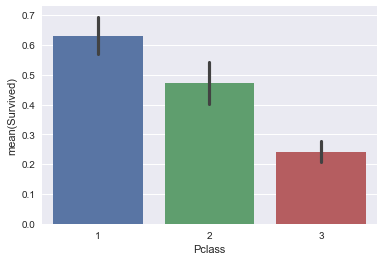

In [23]:
#plot survival rate by class
bcp = sns.barplot(x="Pclass", y="Survived", data=dt)

In [37]:
#perform the chisq test in python using scipy
res = stats.chi2_contingency(pd.crosstab([dt['Survived']], dt['Pclass']).values)
p_value = res[1]
p_value

4.5492517112987927e-23

Because p value < 0.05, we can say that we're able to reject the hypthesis that no difference by class. And from the plot above,we see that the higher the class(1) the higher the survival rate.

#### 2.2 Does survival rate differ within gender?

In [38]:
#count of passengers by gender
dt.groupby('Sex').Survived.size()

Sex
female    314
male      577
dtype: int64

Both groups have enough samples, so its doable to apply the hypothesis test.
Chi-square test in contingency table will also be applied.

##### H0: No difference of survival rate within gender
##### HA: There're differences of survival rate within gender

In [40]:
#survival rate by gender
dt.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

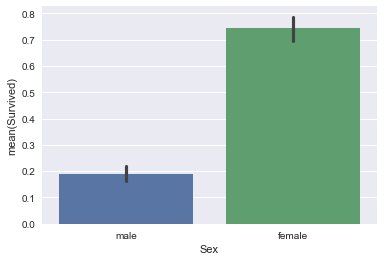

In [41]:
#plot survival rate by gender
bcp = sns.barplot(x="Sex", y="Survived", data=dt)

In [42]:
#perform the chisq test in python using scipy
res = stats.chi2_contingency(pd.crosstab([dt['Survived']], dt['Sex']).values)
p_value = res[1]
p_value

1.1973570627755645e-58

Because p value < 0.05, we can say that we're able to reject the hypthesis that no difference by gender. 
And from the plot above,we see that female survival rate is significantly higher than male.

#### 2.2 Does survival rate differ within age groups?

In [48]:
#count of passengers by age bucket
dt.groupby('age_bucket').Survived.size()

age_bucket
0-10        64
11-20      115
21-30      230
31-40      155
41-50       86
51-60       42
61-70       17
71-80        5
unknown    177
dtype: int64

Because samples with age between 71-80 is too small(only 5), we group 61-80 as a group.

In [50]:
#function of bucket age
def age_bucket(x):
    if x <= 10:
        return '0-10'
    elif x <= 20:
        return '11-20'
    elif x <= 30:
        return '21-30'
    elif x <= 40:
        return '31-40'
    elif x <= 50:
        return '41-50'
    elif x <= 60:
        return '51-60'
    elif x <= 80:
        return '61-80'
    else:
        return 'unknown'

#turn age into bucket
dt['age_bucket'] = dt['Age'].apply(age_bucket)

In [51]:
#count of passengers by age bucket
dt.groupby('age_bucket').Survived.size()

age_bucket
0-10        64
11-20      115
21-30      230
31-40      155
41-50       86
51-60       42
61-80       22
unknown    177
dtype: int64

Since now each bucket group has sample size > 10, i'll apply the same chi-square test to the data.
When applying the test, age bucket 'Unknown' will be eliminated because we don't know the exact age of those passengers and i think applying any predictions like average or knn will bias the test. 

##### H0: No difference of survival rate within age bucket
##### HA: There're differences of survival rate within age bucket

In [53]:
#survival rate by age bucket
dt[dt['age_bucket'] != 'unknown'].groupby('age_bucket').Survived.mean()

age_bucket
0-10     0.593750
11-20    0.382609
21-30    0.365217
31-40    0.445161
41-50    0.383721
51-60    0.404762
61-80    0.227273
Name: Survived, dtype: float64

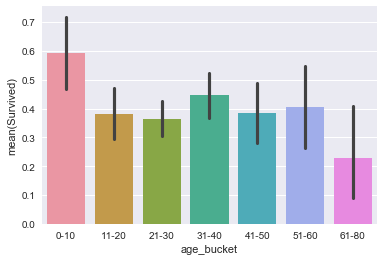

In [56]:
#plot survival rate by age bucket
bcp = sns.barplot(x="age_bucket", y="Survived", data=dt[dt['age_bucket'] != 'unknown']
                  ,order = ['0-10','11-20','21-30','31-40','41-50','51-60','61-80'])

In [57]:
#perform the chisq test in python using scipy
res = stats.chi2_contingency(pd.crosstab([dt[dt['age_bucket'] != 'unknown']['Survived']], dt[dt['age_bucket'] != 'unknown']['age_bucket']).values)
p_value = res[1]
p_value

0.018210172438267894

Because p value < 0.05, we can say that we're able to reject the hypthesis that no difference by age bucket. And from the plot above,we see that passengers from 0-10 yr old has the highest survival rate while whose age higher than 60 has the lowest survival rate. 

# Summary
In this project, i answered 3 questions about if survival rate is impacted by gender, class and age group.
I applied the chi square test in contingency table to test if survival rate is different within each subgroups and by also looking at bar charts of survival rate i found out which subgroup has a higher survival rate.

From the above analysis, we see that survival rate is different within gender, class and age groups. Female has higher survival rate than male, upper class has higher survival rate than middle and lower class, 0-10 yr old passengers has higher survival rate than other age groups.